# Are Facebook shares related to the success of an online petition?

## Setup

Let's start by importing some libraries:
* `numpy` and `pandas` to load, explore, and transform the data
* `matplotlib` and `seaborn` to plot the data

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure plots are shown inside the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## Exploratory data analysis

Let's now load the data!

In [44]:
petitions = pd.read_csv('https://learn.estimand.com/datasets/petitions.csv.gz', index_col=0, compression='gzip')

We start our exploration by simply printing the first 5 rows; this is the default setting for `head()`.

In [45]:
petitions.head()

,action,opened_at,total_signatures,uk_signatures,fb_shares
id,,,,,
104309,Introduce a rate increase cap on pay TV pricin...,2015-07-20 13:35:32.499,22,22,6
104311,Impose a heavy extra tax on foreign buyers of ...,2015-07-20 11:05:07.590,383,380,72
104317,Hold a referendum on electoral reform with the...,2015-07-20 13:39:20.344,4767,4701,2361
104318,Make the 'Steam' refund policy the law for all...,2015-07-21 15:30:55.362,94,92,13
104319,Ban unpaid internships,2015-07-20 13:55:48.630,438,436,70


We can see that there are 5 columns (plus `id` which acts as the index), but how many rows are there?
The attribute `shape` gives the number of rows (observations) and columns (variables) in our `DataFrame`.

In [46]:
petitions.shape

(3582, 5)

Each column corresponds to a variable, and has an associated **data type** which can be accessed using `dtypes`.

In [47]:
petitions.dtypes

action              object
opened_at           object
total_signatures     int64
uk_signatures        int64
fb_shares            int64
dtype: object

As we saw above, `opened_at` represents the date and time when the petition went live. `pandas` has many useful functions to deal with `datetime` objects, so let's convert `opened_at` to the proper data type.

In [48]:
petitions['opened_at'] = pd.to_datetime(petitions['opened_at'])

In [49]:
petitions.dtypes

action                      object
opened_at           datetime64[ns]
total_signatures             int64
uk_signatures                int64
fb_shares                    int64
dtype: object

We are now ready to explore the data! Let's start by 'describing' a single column, for example `total_signatures`.

In [50]:
# Up to you!

count      3582.000000
mean       3909.531826
std       26099.244047
min           6.000000
25%          27.000000
50%          86.000000
75%         641.750000
max      823348.000000
Name: total_signatures, dtype: float64

A graphical representation of this information is the box plot.

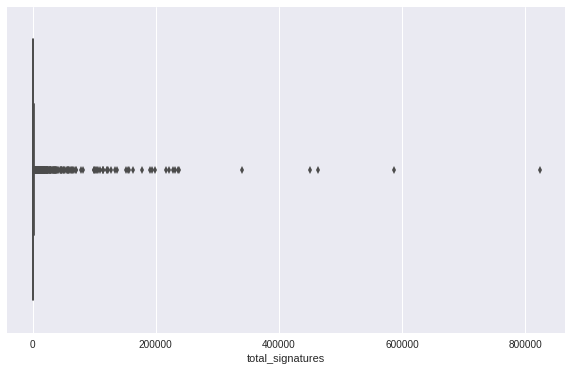

In [51]:
sns.boxplot(petitions['total_signatures'])

What's going on here?! As we saw using `describe()`, the total number of signatures varies enormously (from 6 to more than 800,000!), but only very few petitions actually have a huge number of signatures.

When this happens, it's sometimes useful to apply certain **transformations** such as the logarithm. Let's see if this works here!

In [52]:
petitions['total_signatures'] = np.log(petitions['total_signatures'])

In [53]:
petitions['total_signatures'].describe()

count    3582.000000
mean        5.048422
std         2.228558
min         1.791759
25%         3.295837
50%         4.454347
75%         6.464199
max        13.621134
Name: total_signatures, dtype: float64

The standard deviation has dropped significantly! What happens if we try to produce a box plot again?

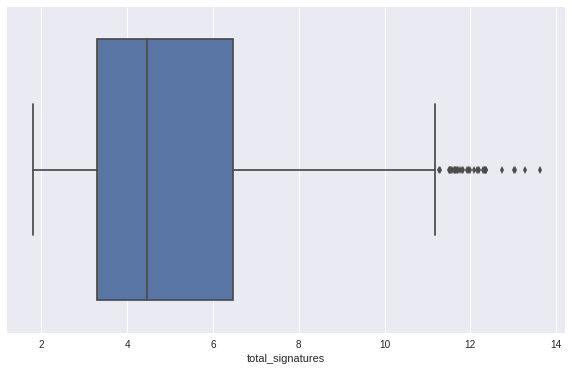

In [54]:
# Up to you!

A complementary visualisation is the kernel density estimate. You can think of it as a 'continuous' version of a histogram, with the added bonus that you don't have to arbitrarily pick the number of bins.

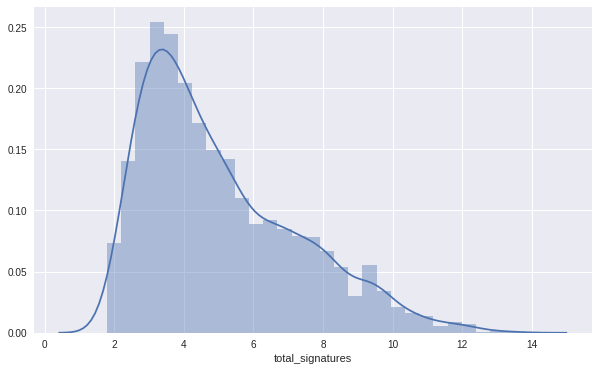

In [55]:
# Up to you!

When dealing with categorical variables (or numerical variables with few unique values), it's useful to count how many times each unique value occurs.

In [56]:
petitions['opened_at'].dt.year.value_counts()

2015    2172
2016    1410
Name: opened_at, dtype: int64

Note how we can access `datetime`-specific functions directly using `dt`. By 'chaining together' multiple methods, we can quickly build interesting visualisations!

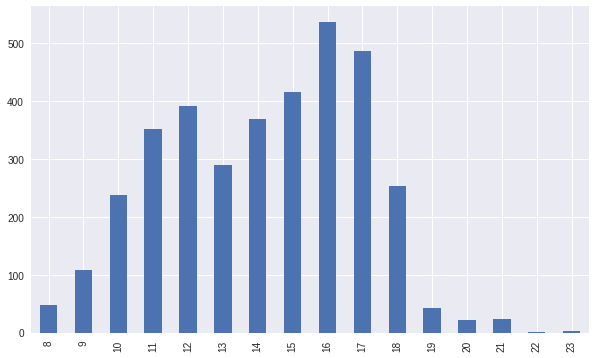

In [57]:
petitions['opened_at'].dt.hour.value_counts().sort_index().plot.bar()

`pandas` provides powerful functions to work with time series. For example, using `resample()` we can aggregate our data at monthly (or any other!) resolution.

In [58]:
petitions.set_index('opened_at').resample('M').action.count()

opened_at
2015-07-31    281
2015-08-31    360
2015-09-30    468
2015-10-31    301
2015-11-30    370
2015-12-31    392
2016-01-31    434
2016-02-29    558
2016-03-31    418
Freq: M, Name: action, dtype: int64

And plot the result, of course!

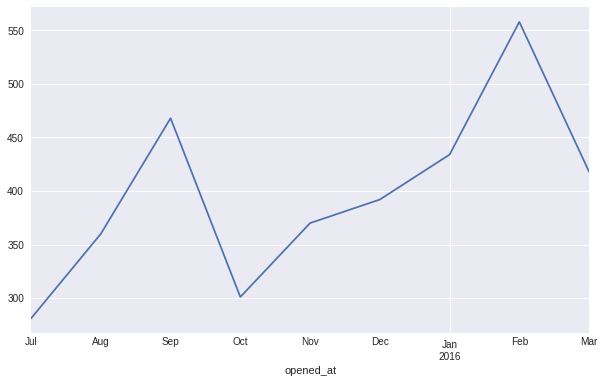

In [59]:
petitions.set_index('opened_at').resample('M').action.count().plot.line()

We can also easily obtain monthly statistics, for example the average number of signatures for petitions started in a given month.

In [60]:
petitions.set_index('opened_at').resample('M').total_signatures.mean()

opened_at
2015-07-31    5.996021
2015-08-31    5.296168
2015-09-30    4.933572
2015-10-31    4.910422
2015-11-30    5.116763
2015-12-31    4.716353
2016-01-31    4.881812
2016-02-29    5.016434
2016-03-31    4.892596
Freq: M, Name: total_signatures, dtype: float64

And plot it again!

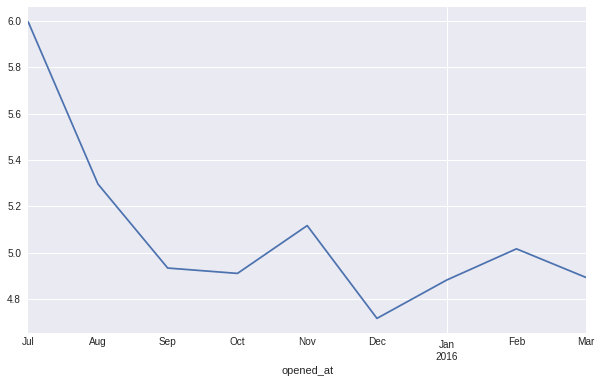

In [61]:
# Up to you!

We could spend *a lot* of time playing with the data, but let's focus on the problem at hand!

**Over to you now**: have a look at the variable `fb_shares`!

Let's now explore the association between the transformed `total_signatures` and `fb_shares`!

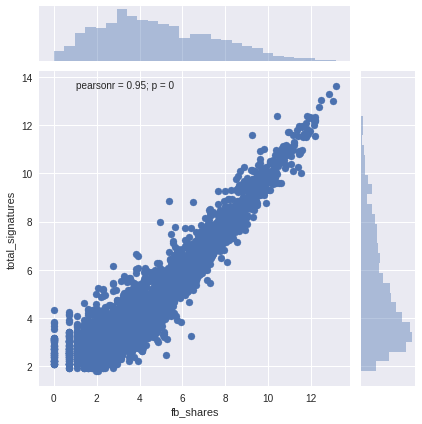

In [68]:
sns.jointplot(petitions['fb_shares'], petitions['total_signatures'])

## Modelling

### Traditional statistics

It looks like `total_signatures` and `fb_shares` are strongly correlated, but how can we formally assess this association?

Let's start by loading `statsmodels`, another library that implements most 'traditional statistics' models with a simple interface (reminiscent of `R`).

In [69]:
import statsmodels.formula.api as smf

We will try a linear model (implemented in `statsmodels` as `ols`, ordinary least squares), which assumes the relationship between our two variables is:

$$
    \text{Total signatures} = \beta_{0} + \beta_{1} \times \text{Facebook shares}
$$

The **intercept** $\beta_{0}$ represents the total number of signatures for a petition that has never been shared on Facebook, whereas the **regression coefficient** $\beta_{1}$ represents how many (more/less, depending on the sign) signatures are associated with an additional Facebook share.

In our case, remember that we transformed both `total_signatures` and `fb_shares`, meaning that our model is actually:

$$
    \log(\text{Total signatures}) = \beta_{0} + \beta_{1} \times \log(\text{Facebook shares})
$$

Note that this model is equivalent to:

$$
    \text{Total signatures} = e^{\beta_{0}} \times (\text{Facebook shares})^{\beta_{1}}
$$

Where we have applied a logarithmic transformation on both sides (exactly what we did!).

You can read more about the log-log model [here](http://www.dummies.com/education/economics/econometrics/econometrics-and-the-log-log-model/). For interpretation, just remember that the coefficient $\beta_{1}$ is the estimated *percentage change* in the total number of signatures for a 1% increase in Facebook shares.

In [70]:
model1 = smf.ols('total_signatures ~ fb_shares', data=petitions).fit()

Let's now have a look at the output of the model.

In [71]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_signatures   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 3.059e+04
Date:                Wed, 31 May 2017   Prob (F-statistic):               0.00
Time:                        10:47:24   Log-Likelihood:                -3912.2
No. Observations:                3582   AIC:                             7828.
Df Residuals:                    3580   BIC:                             7841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1950      0.025     47.579      0.000       1.146       1.244
fb_shares      0.8081      0.005    174.894      0.000       0.799       0.817
==============================================================================
Omnibus:                      149.581   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.678
Skew:                           0.433   Prob(JB):                     5.32e-43
Kurtosis:                       3.745   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can conclude that a 1% increase in Facebook shares is associated with a 0.8% increase in signatures.
The association is highly 'statistically significant' (very small $p$-value), and the model fits the data well ($R^{2}$ almost 0.9).

### Feature engineering

Feature engineering is the process of incorporating domain knowledge in the data by devising new variables (*features* in machine learning parlance). Very often this leads to better models, but it's difficult and can be expensive!

Let's try to 'engineer' some features based on the `action` variable. For example, we could select some hot keywords such as 'ban' and 'stop', or heavily debated topics such as the NHS.

In [72]:
petitions['ban_stop'] = petitions.action.str.contains('ban', case=False) |\
                        petitions.action.str.contains('stop', case=False)
petitions['nhs'] = petitions.action.str.contains('NHS', case=False)

The regression coefficients for `ban_stop` and `nhs` represent the percentage change in the total number of signatures when the words 'ban' or 'stop' are present, or the NHS is mentioned, **all else unchanged**.

In [73]:
model2 = smf.ols('total_signatures ~ fb_shares + ban_stop + nhs', data=petitions).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_signatures   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                 1.021e+04
Date:                Wed, 31 May 2017   Prob (F-statistic):               0.00
Time:                        10:47:24   Log-Likelihood:                -3908.9
No. Observations:                3582   AIC:                             7826.
Df Residuals:                    3578   BIC:                             7851.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1867      0.026     46.406      0.000       1.137       1.237
ban_stop[T.True]     0.0752      0.033      2.247      0.025       0.010       0.141
nhs[T.True]         -0.0778      0.062     -1.259      0.208      -0.199       0.043
fb_shares            0.8080      0.005    174.839      0.000       0.799       0.817
==============================================================================
Omnibus:                      149.169   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.157
Skew:                           0.430   Prob(JB):                     4.19e-43
Kurtosis:                       3.754   Cond. No.                         28.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model fit (represented by the $R^{2}$ value) didn't improve significantly, yet the association with `ban_stop` is 'statistically significant' ($p$-value below 5%).